In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
from matplotlib.colors import Normalize

In [2]:
original = pd.read_csv('winequality-red.csv', sep=';')

In [3]:
df = original
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


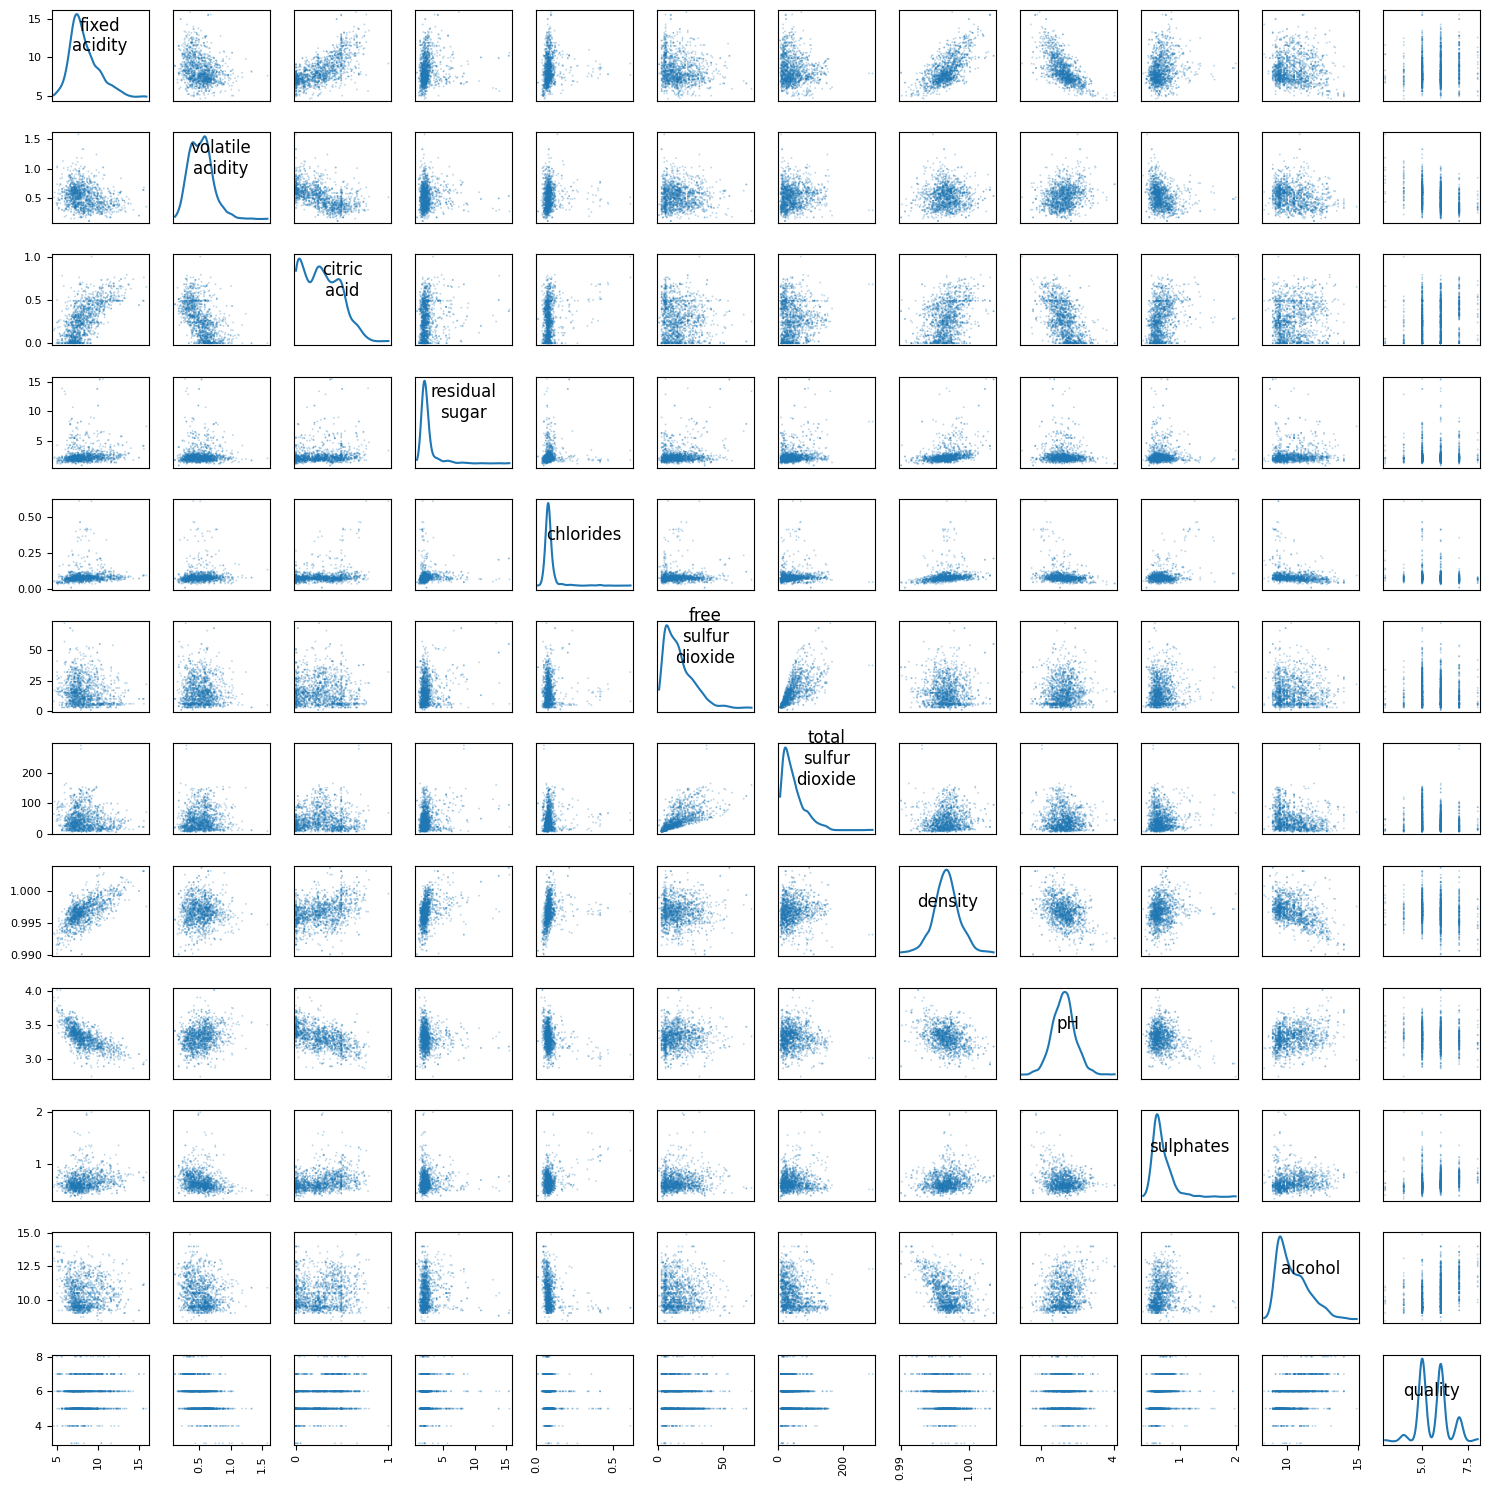

In [4]:
axes = pd.plotting.scatter_matrix(df, alpha=0.3, s=7, figsize=(15, 15), diagonal='kde')
plot_labels = [label.replace(' ', '\n') for label in df.columns]

for i, ax in enumerate(axes.flatten()):
    ax.yaxis.label.set_ha('right')
    if i % (len(df.columns) + 1) == 0:
        ax.text(0.5, 0.5, plot_labels[i // len(df.columns)], horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [5]:
X = df.drop('quality', axis=1)
y = df['quality']
# normalize features
X = (X - X.mean()) / X.std()

In [6]:
X = sm.add_constant(X)
full_model = sm.OLS(y, X).fit()
print(full_model.summary())
print()
def stepwise_regression(X, y, significance_level=0.05):
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    while True:
        pvalues = model.pvalues.drop(index=['const'])
        
        if all(pvalues < significance_level):
            break
        
        max_pvalue = pvalues.max()
        if max_pvalue < significance_level:
            break
        
        max_pvalue_variable = pvalues.idxmax()
        print(f"Dropping variable '{max_pvalue_variable}' with p-value {max_pvalue}")
        X = X.drop(columns=[max_pvalue_variable])
        
        model = sm.OLS(y, X).fit()
    
    return model

final_model = stepwise_regression(X, y)
print()
print("Selected Model")
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Mon, 10 Jun 2024   Prob (F-statistic):          1.79e-145
Time:                        01:26:04   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:                    1587   BIC:                             3227.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6360 

In [7]:
y = (y - y.mean()) / y.std()

In [8]:
X.drop('const', axis=1, inplace=True)
df = pd.concat([X, y], axis=1)

In [9]:
# PCA
pca = PCA()
principalComponents = pca.fit_transform(df)

In [10]:
# eigenvalues
eigenvalues = pca.explained_variance_
eigenvalues

array([3.1211677 , 2.24188204, 1.68291969, 1.21502087, 0.97326362,
       0.66259224, 0.6183178 , 0.50587256, 0.41130754, 0.32791939,
       0.18021863, 0.05951792])

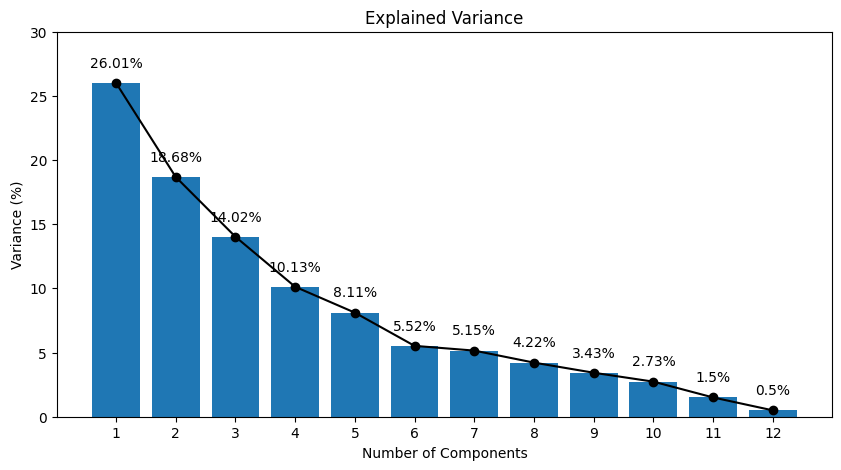

In [11]:
explained_var_ratio = pca.explained_variance_ratio_ * 100

plt.figure(figsize=(10,5))
bars = plt.bar(range(1,len(explained_var_ratio)+1), explained_var_ratio)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1,
             f'{round(yval,2)}%', ha='center', va='bottom')

plt.plot(range(1,len(explained_var_ratio)+1), explained_var_ratio, color='black', marker='o')

plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.ylim(0,30)
plt.xticks(range(1,len(explained_var_ratio)+1))
plt.show()


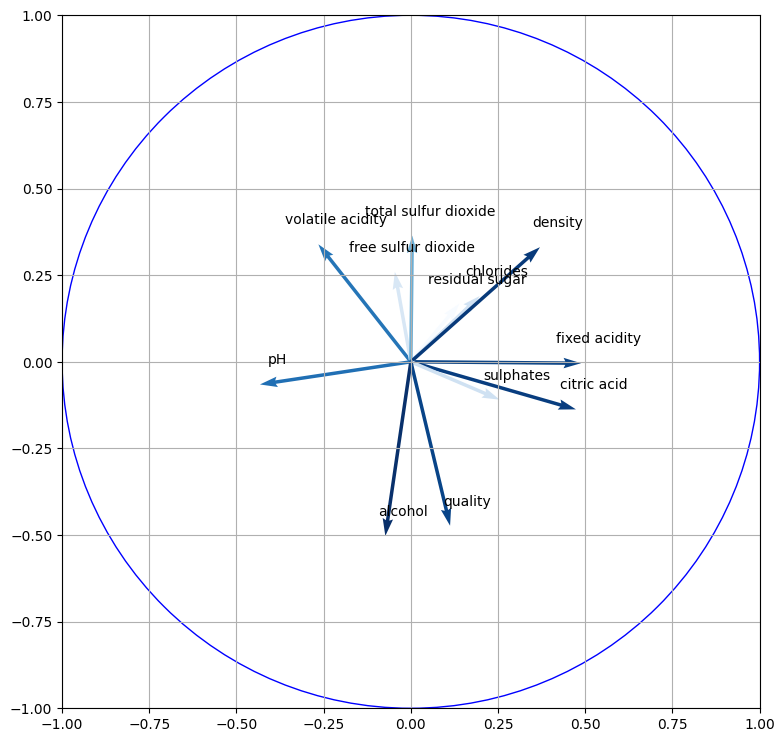

In [12]:
arrow_width = 0.005
cmap_name = 'Blues'

distances = np.sqrt(pca.components_[0, :]**2 + pca.components_[1, :]**2)
norm = Normalize(vmin=min(distances), vmax=max(distances))
colors = plt.get_cmap(cmap_name)(norm(distances))

plt.figure(figsize=(9, 9))
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.quiver(
    np.zeros(pca.components_.shape[1]), 
    np.zeros(pca.components_.shape[1]),
    pca.components_[0, :], 
    pca.components_[1, :], 
    angles='xy', 
    scale_units='xy', 
    scale=1,
    color=colors, 
    width=arrow_width
)

for i, j, z in zip(pca.components_[0, :] + 0.05, pca.components_[1, :] + 0.05, df.columns):
    plt.text(i, j, z, ha='center', va='bottom')

circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

plt.grid()
plt.show()


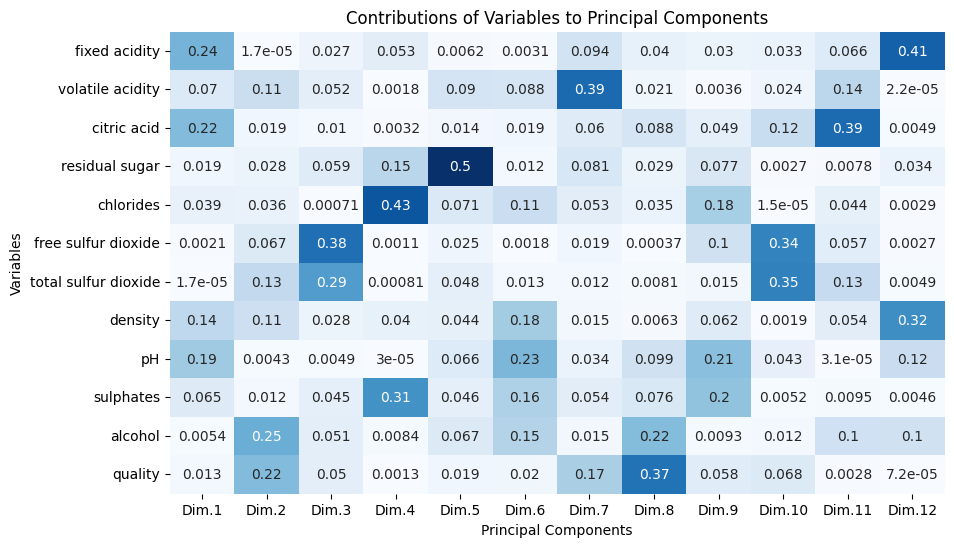

In [13]:
loadings = pca.components_.T ** 2
contributions = loadings / loadings.sum(axis=0)

contrib_df = pd.DataFrame(contributions, columns=[f'Dim.{i+1}' for i in range(loadings.shape[1])], index=df.columns)

plt.figure(figsize=(10, 6))
sns.heatmap(contrib_df, annot=True, cmap='Blues', cbar=False)
plt.title('Contributions of Variables to Principal Components')
plt.ylabel('Variables')
plt.xlabel('Principal Components')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

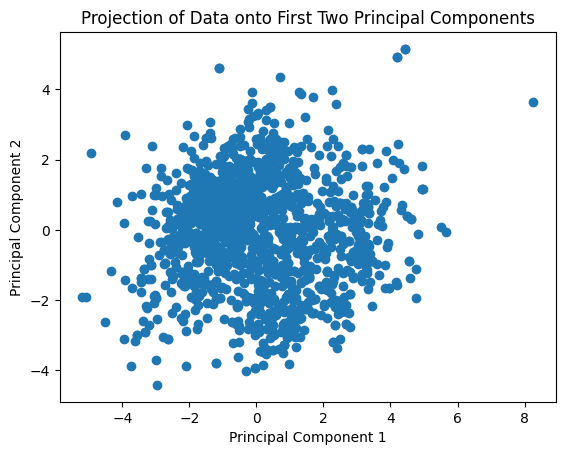

In [14]:
transformed_data = pca.transform(df)

pc1 = transformed_data[:, 0]
pc2 = transformed_data[:, 1]

plt.scatter(pc1, pc2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Projection of Data onto First Two Principal Components')
plt.show()

In [15]:
df = original
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [16]:
from sklearn.linear_model import Lasso

X = df.drop('quality', axis=1)
y = df['quality']
# normalize features
X = (X - X.mean()) / X.std()
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)

selected_variables = X.columns[lasso.coef_ != 0]
selected_variables

Index(['volatile acidity', 'residual sugar', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates',
       'alcohol'],
      dtype='object')

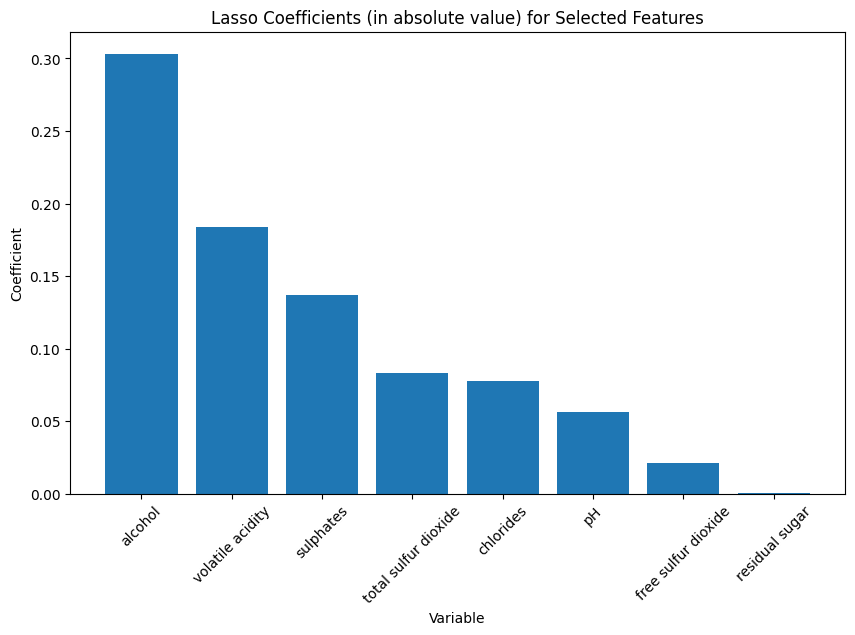

In [17]:
coefficients = np.abs(lasso.coef_[lasso.coef_ != 0])

pairs = list(zip(selected_variables, coefficients))

pairs.sort(key=lambda x: x[1], reverse=True)

sorted_variables, sorted_coefficients = zip(*pairs)

plt.figure(figsize=(10, 6))
plt.bar(sorted_variables, sorted_coefficients)
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.title('Lasso Coefficients (in absolute value) for Selected Features')
plt.xticks(rotation=45)
plt.show()